# DEFINE PROBLEM

- Financial industry has the highest customers churning rate compared to other industry which about 25%
    - Source: https://www.statista.com/statistics/816735/customer-churn-rate-by-industry-us/
- The cost of acquiring new customers is estimated at five times the rate of retaining existing ones
    - Source : https://www.fpsc.com/the_cost_of_customer_churn.pdf

# DEFINE GOALS

- Help bank to create strategy preventing customers move to competitor by understanding customers behaviour through customes churn prediction
- Find out which features/columns affecting customers to churn
- This research will be utilized to created customers churn prediction Machine Learning Model  

### IMPORT COMMON PACKAGE

In [1]:
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dython
from dython.nominal import associations, cramers_v, correlation_ratio, theils_u
import dateparser
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_columns = 999

### IMPORT FILE

In [2]:
df = pd.read_csv('Churn_Modelling.csv')

### DATA TYPE OVERALL CHECK

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


##### COLUMNS DESCRIPTION
`RowNumber` - The number of the row\
`CustomerId` - The unique customer id\
`Surname` - Customer's Surname\
`CreditScore` - Customer's Credit Score \
`Geograhpy` - Customer's Living Location\
`Gender` - Customer's Gender\
`Age` - Customer's Age\
`Tenure` - The time of bond with company\
`Balance` - The amount left with them \
`NumOfProduct` - The products they own\
`HasCrCard` - Customer's Credit Card Ownership => 1: Has CreditCard; 0: Doesn't have Credit Card\
`IsActiveMember` - Customer's Active Member Status => 1: Active Member; 0: Not Active Member \
`EstimatedSalary` - Customer's Estimated Salary \
`Exited` - Customer Exited Status => 1: Exited; 0 Non Exited

Source : https://www.kaggle.com/shubh0799/churn-modelling

In [4]:
print(df.shape)

(10000, 14)


### COLUMN SUMMARY

In [5]:
dfDesc = []
for i in df.columns:
    dfDesc.append([
        i, 
        df[i].dtypes,
        df[i].isna().sum(),
        round(((df[i].isna().sum()/ len(df)) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

In [6]:
pd.DataFrame(data = dfDesc,
             columns = [
                 'Features', 
                 'DataType', 
                 'Null', 
                 'NullPercentage', 
                 'Unique', 
                 'Unique Sample'
             ])

,Features,DataType,Null,NullPercentage,Unique,Unique Sample
0,RowNumber,int64,0,0.00,10000,"[9194, 9979]"
1,CustomerId,int64,0,0.00,10000,"[15693162, 15765402]"
2,Surname,object,0,0.00,2932,"[Distefano, Custance]"
3,CreditScore,int64,0,0.00,460,"[701, 648]"
4,Geography,object,0,0.00,3,"[France, Germany]"
5,Gender,object,0,0.00,2,"[Male, Female]"
6,Age,int64,0,0.00,70,"[22, 73]"
7,Tenure,int64,0,0.00,11,"[5, 3]"
8,Balance,float64,0,0.00,6382,"[188241.05, 161064.64]"
9,NumOfProducts,int64,0,0.00,4,"[1, 3]"


In [7]:
## df.head(), df.shape, df.info() is utilized to capture dataset genereal information

## DATA PREPARATION BEFORE OUTLIERS & MISSING VALUE CHECKING

- Remove unecessary columns => RowNumber & Surname

In [8]:
df.drop(columns = ['RowNumber','Surname'], inplace = True)

# DESCRIPTIVE ANALYSIS, HANDLING OUTLIERS, AND HANDLING MISSING VALUE

### DESCRIPTIVE ANALYSIS

In [9]:
round(df.describe(),2)
# The lowest CreditScore is 350
# The highest CreditScore is 850
# The average CreditScore is 650
# Average Customer's Age are 38 years old
# Average Customer's Tenure is 5 years old (Max Tenure is 10 years)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.00
75%,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


### OUTLIERS CHECK & HANDLING

In [10]:
outliers = []
def cek_outlier(data):
    sorted(data)
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3-q1
    lower_fence = q1 - (1.5 * iqr)
    upper_fence = q3 + (1.5 * iqr)
    for i in data:
        if i < lower_fence or i > upper_fence:
            outliers.append(i)
    return outliers

In [11]:
# function to get unique values
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
            
    return unique_list

In [12]:
outliers = []
cek_outlier(df['CreditScore'])
print(len(outliers))
unique(outliers)
## There are 15 Outliers of CreditScore
## Since the data is needed, CreditScore outliers will not be removed

15


[376, 363, 359, 350, 358, 351, 365, 367, 382, 373]

In [13]:
df[df['CreditScore'].isin(outliers)]

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
942,15804586,376,France,Female,46,6,0.00,1,1,0,157333.69,1
1193,15779947,363,Spain,Female,28,6,146098.43,3,1,0,100615.14,1
1405,15612494,359,France,Female,44,6,128747.69,1,1,0,146955.71,1
1631,15685372,350,Spain,Male,54,1,152677.48,1,1,1,191973.49,1
1838,15758813,350,Germany,Male,39,0,109733.20,2,0,0,123602.11,1
1962,15692416,358,Spain,Female,52,8,143542.36,3,1,0,141959.11,1
2473,15679249,351,Germany,Female,57,4,163146.46,1,1,0,169621.69,1
2579,15597896,365,Germany,Male,30,0,127760.07,1,1,0,81537.85,1
8154,15791533,367,Spain,Male,42,6,93608.28,1,1,0,168816.73,1


In [14]:
outliers = []
cek_outlier(df['Age'])
print(len(outliers))
unique(outliers)
## There are 359 customers which age are outliers

359


[66,
 75,
 65,
 73,
 72,
 67,
 79,
 80,
 68,
 70,
 63,
 64,
 82,
 69,
 74,
 71,
 76,
 77,
 88,
 85,
 84,
 78,
 81,
 92,
 83]

In [15]:
outliers = []
cek_outlier(df['Tenure'])
print(len(outliers))
unique(outliers)

0


[]

In [16]:
outliers = []
cek_outlier(df['Balance'])
print(len(outliers))
unique(outliers)

0


[]

In [17]:
outliers = []
cek_outlier(df['EstimatedSalary'])
print(len(outliers))
unique(outliers)

0


[]

In [18]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


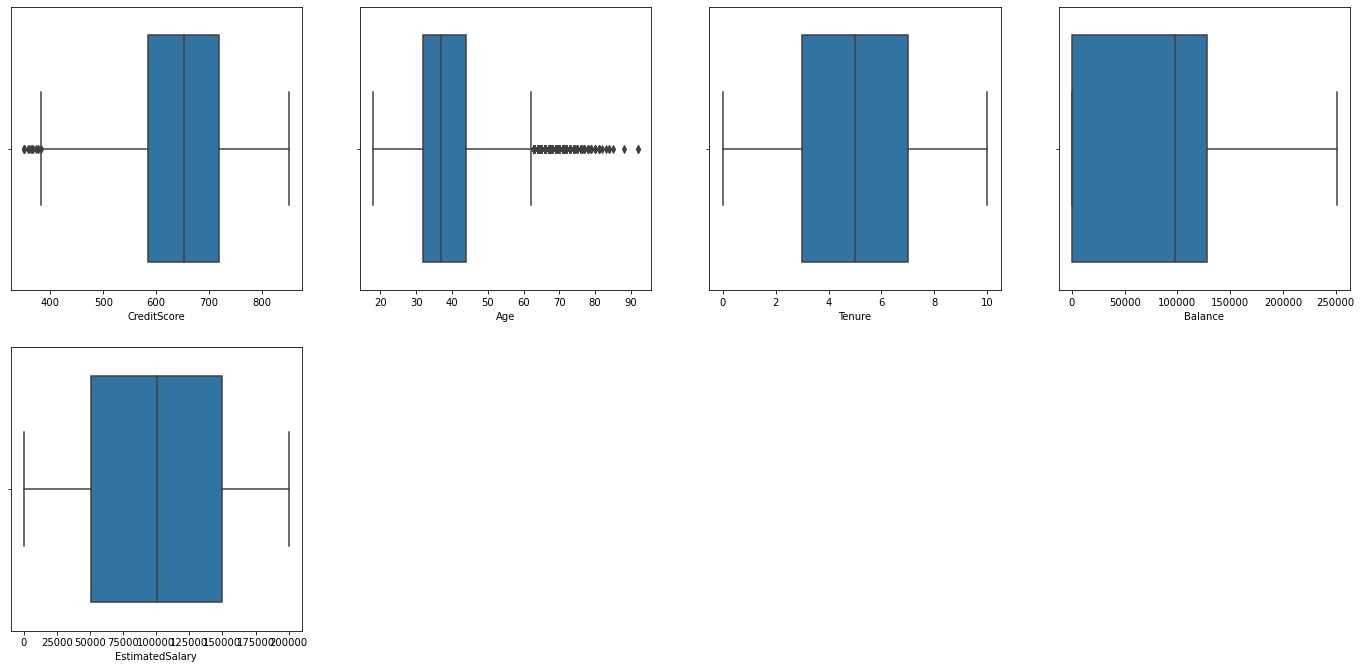

In [19]:
## Plot Boxplot For Numerical Columns to show distribution data & outliers value
df_outliers = df.drop(columns = ['CustomerId', 'Geography', 'Gender','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited'])

plt.figure(figsize =(24, 24))
x = 1 

for column in df_outliers.columns:
    plt.subplot(4,4,x)
    sns.boxplot(df_outliers[column])
    x+=1
    
plt.show()

- Only CreditScore and Age Features which have Outliers Value => This outliers will not be removed since it might be useful 

### MISSING VALUE CHECK & HANDLING

In [20]:
df.isna().sum()
## From information below, dataset don't have missing value

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# DATA PREPARATION - FEATURES ENGINEERING

### FEATURES ENGINEERING FOR EDA

- Binning Credit Score based on https://www.experian.com/blogs/ask-experian/credit-education/score-basics/what-is-a-good-credit-score/
- Binning Age

#### Binning Credit Score

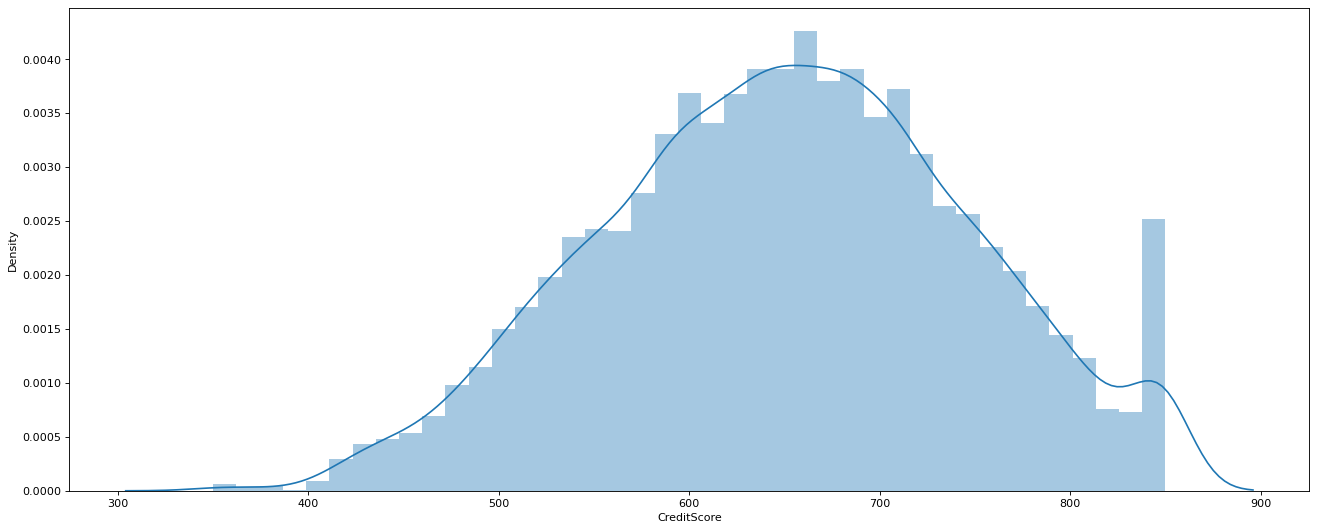

In [21]:
## Credit Score Distribution Data
plt.figure(figsize=(20,8), dpi = 80)
sns.distplot(df['CreditScore'])
plt.show()

In [22]:
df['CreditScore'].min()

350

In [23]:
credit_score_bin = [300, 579, 669, 739, 799, df['CreditScore'].max()]
credit_score_label = ['Very Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']

df['credit_score_group'] = pd.cut(df['CreditScore'], bins = credit_score_bin, labels = credit_score_label)

#### Binning Age

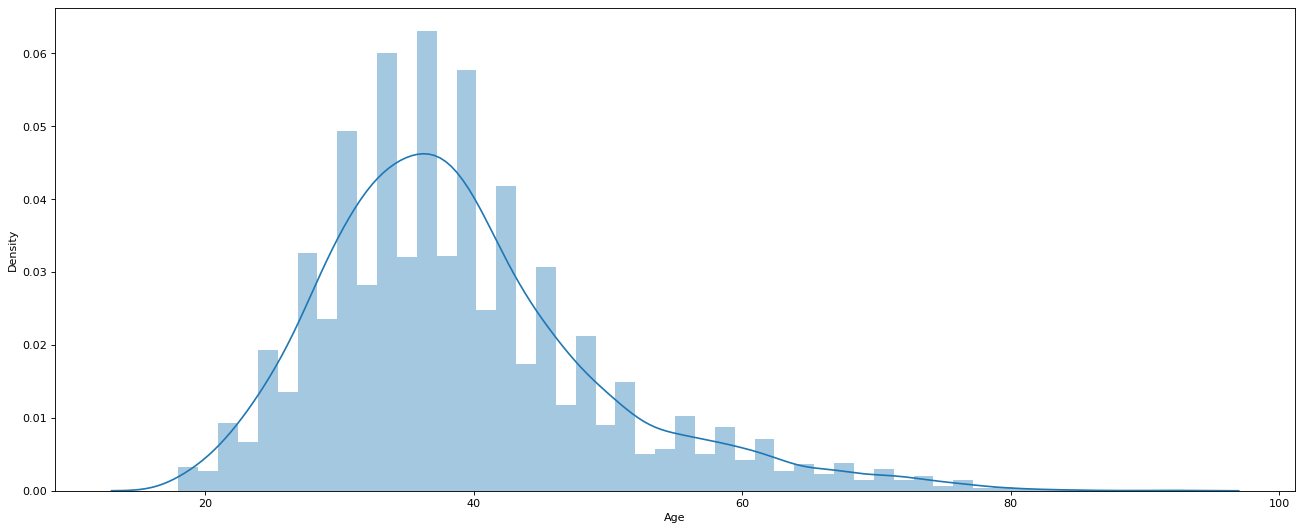

In [24]:
## Age Distribution Data
plt.figure(figsize=(20,8), dpi = 80)
sns.distplot(df['Age'])
plt.show()

In [25]:
age_bin = [17, 30, 45, df['Age'].max()]
age_label = ['Young Adults', 'Middle-Aged Adults', 'Old Adults']

df['age_group'] = pd.cut(df['Age'], bins = age_bin , labels = age_label)

# EXPLORATORY DATA ANALYSIS & DATA VISUALIZATION

##### Initial Hypothesis 
- Credit Score affect Customer's loyalty
- Geography affect Customer's loyalty
- Gender affect Customer's loyalty
- Age affect Customer's loyalty
- Tenure affect Customer's loyalty
- Balance affect Customer's loyalty
- Num of Products affect Customer's loyalty
- Credit Card Ownership affect Customer's loyalty
- Active Member Status affect Customer's loyalty
- Estimated Salary affect Customer's loyalty

### CORELLATION ANALYSIS

In [26]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,credit_score_group,age_group
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Fair,Middle-Aged Adults
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Fair,Middle-Aged Adults
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Very Poor,Middle-Aged Adults
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Good,Middle-Aged Adults
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Exceptional,Middle-Aged Adults


### Association

In [27]:
df_aso = df.drop(columns = ['CustomerId','CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'credit_score_group'])

In [28]:
df_aso.head()

,Geography,Gender,Tenure,HasCrCard,IsActiveMember,Exited,age_group
0,France,Female,2,1,1,1,Middle-Aged Adults
1,Spain,Female,1,0,1,0,Middle-Aged Adults
2,France,Female,8,1,0,1,Middle-Aged Adults
3,France,Female,1,0,0,0,Middle-Aged Adults
4,Spain,Female,2,1,1,0,Middle-Aged Adults


In [29]:
assoc_theils = []

for i in df_aso.columns:
    assoc = round(theils_u(df_aso['Exited'], df[i]), 2)
    assoc_theils.append(assoc)

In [30]:
data_theils = pd.DataFrame(data = [assoc_theils], columns = df_aso.columns, index=['Exited'])

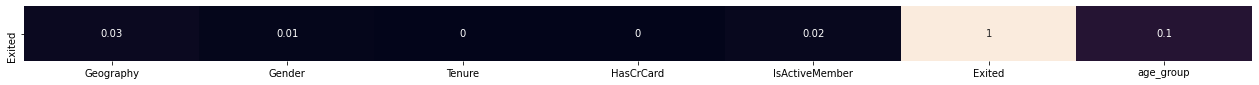

In [31]:
plt.figure(figsize=(22, 1))
sns.heatmap(data_theils, annot=True, cbar=False)
plt.show()

### Correlation Ratio

In [32]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,credit_score_group,age_group
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Fair,Middle-Aged Adults
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Fair,Middle-Aged Adults
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Very Poor,Middle-Aged Adults
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Good,Middle-Aged Adults
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Exceptional,Middle-Aged Adults


In [33]:
df_corat = df.drop(columns = ['CustomerId', 'Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'credit_score_group', 'age_group'])

In [34]:
df_corat.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited
0,619,42,2,0.00,101348.88,1
1,608,41,1,83807.86,112542.58,0
2,502,42,8,159660.80,113931.57,1
3,699,39,1,0.00,93826.63,0
4,850,43,2,125510.82,79084.10,0


In [35]:
corat_list = []

for i in df_corat.columns:
    corat = round(correlation_ratio(df_corat['Exited'], df[i]), 2)
    corat_list.append(corat)

In [36]:
data_corat = pd.DataFrame(data = [corat_list], columns = df_corat.columns, index=['Exited'])

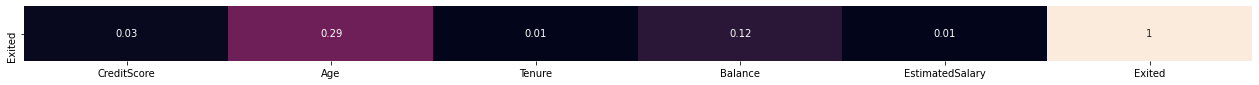

In [37]:
plt.figure(figsize=(22, 1))
sns.heatmap(data_corat, annot=True, cbar=False)
plt.show()

In [38]:
## To ensure corelation, further analysis will be conducted

### UNIVARIATE ANALYSIS

#### Price

In [39]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

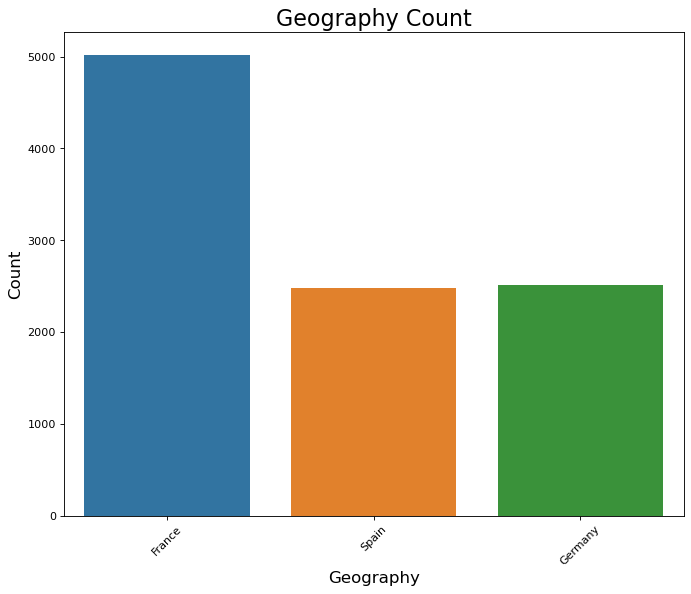

In [40]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df['Geography'])
plt.title('Geography Count', size =20)
plt.xlabel("Geography",size = 15)
plt.ylabel("Count", size = 15)
plt.xticks(rotation=45)
plt.show()

- Majority customers live at France

#### Gender

In [41]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [42]:
df['Gender'].value_counts(normalize=True)

Male     0.55
Female   0.45
Name: Gender, dtype: float64

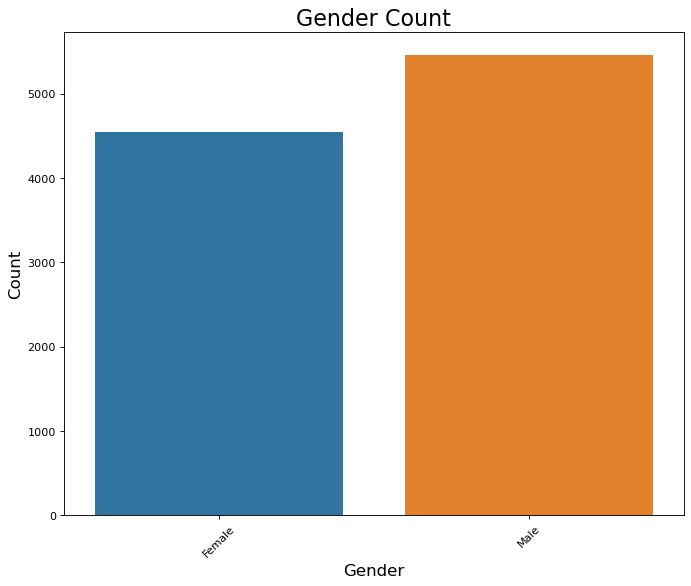

In [43]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df['Gender'])
plt.title('Gender Count', size =20)
plt.xlabel("Gender",size = 15)
plt.ylabel("Count", size = 15)
plt.xticks(rotation=45)
plt.show()

- 55% of customers are Male

#### Age Group

In [44]:
df['age_group'].value_counts()

Middle-Aged Adults    5921
Old Adults            2111
Young Adults          1968
Name: age_group, dtype: int64

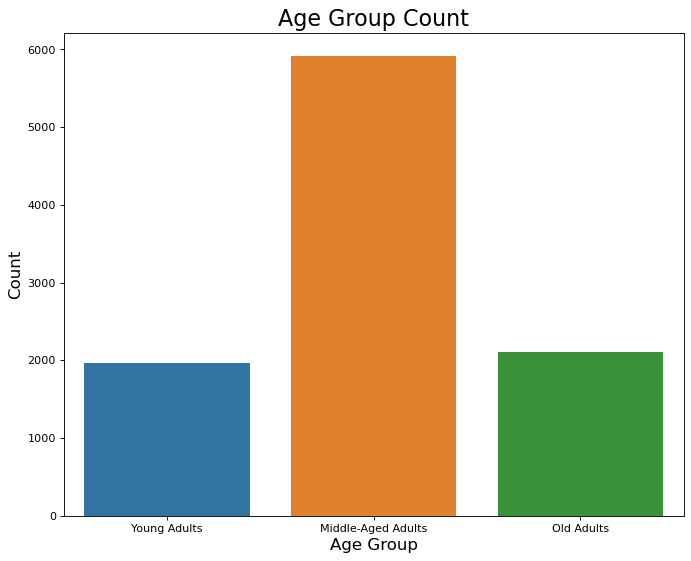

In [45]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df['age_group'])
plt.title('Age Group Count', size =20)
plt.xlabel("Age Group",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Majority customers are in Middle-Aged Adults

#### Tenure

In [46]:
df['Tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

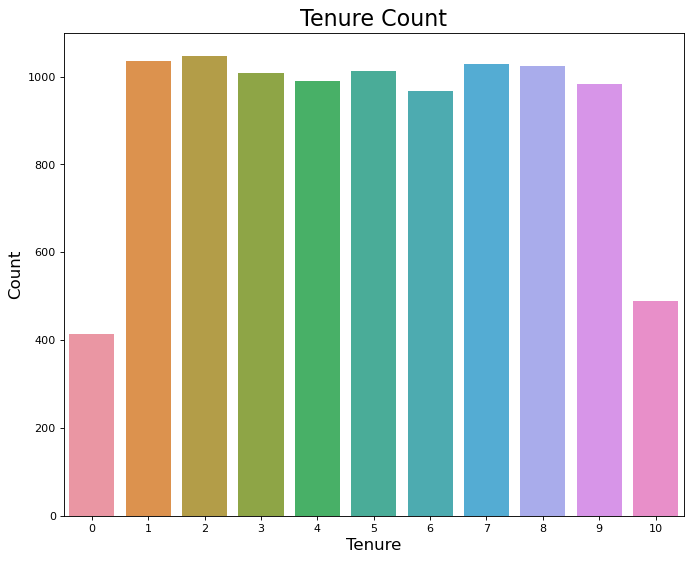

In [47]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df['Tenure'])
plt.title('Tenure Count', size =20)
plt.xlabel("Tenure",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- All Tenure period has similar number of customers

#### Num Of Products

In [48]:
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

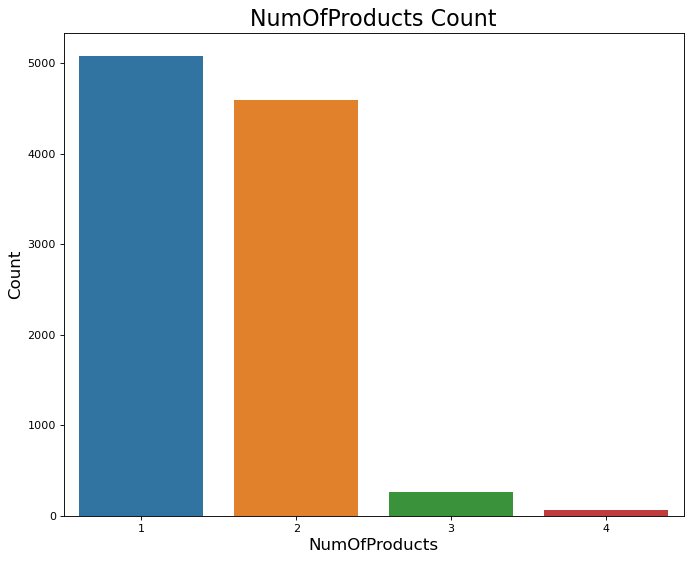

In [49]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df['NumOfProducts'])
plt.title('NumOfProducts Count', size =20)
plt.xlabel("NumOfProducts",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Majority customers have one or two number of products

#### Credit Card Ownership

In [50]:
df['HasCrCard'].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

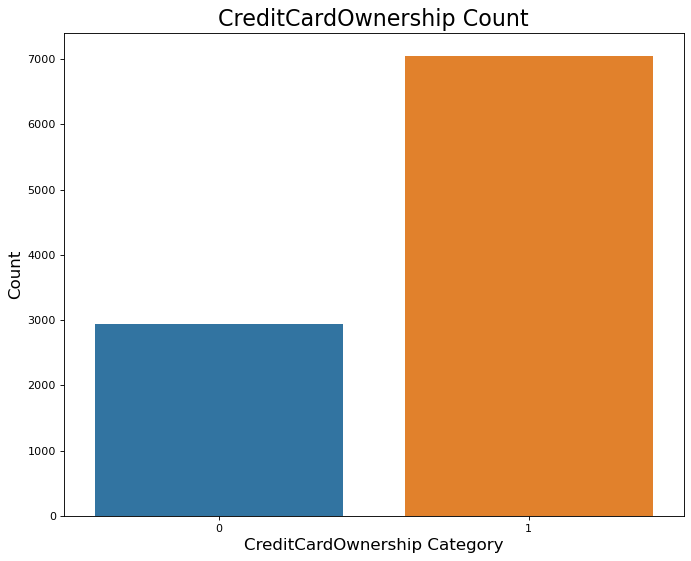

In [51]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df['HasCrCard'])
plt.title('CreditCardOwnership Count', size =20)
plt.xlabel("CreditCardOwnership Category",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Majority customers have credit card

#### Membership Status

In [52]:
df['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

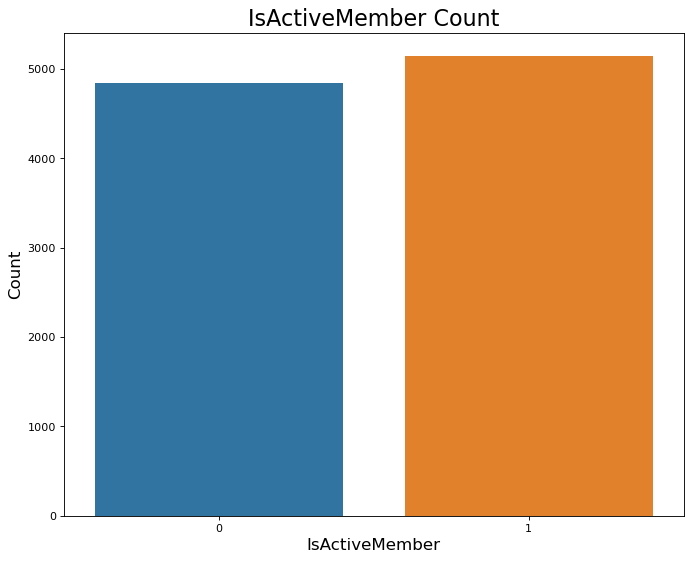

In [53]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df['IsActiveMember'])
plt.title('IsActiveMember Count', size =20)
plt.xlabel("IsActiveMember",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Number of Active Customers are similar to Number of NonActive Customers

#### Exited

In [54]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [55]:
df['Exited'].value_counts(normalize=True)

0   0.80
1   0.20
Name: Exited, dtype: float64

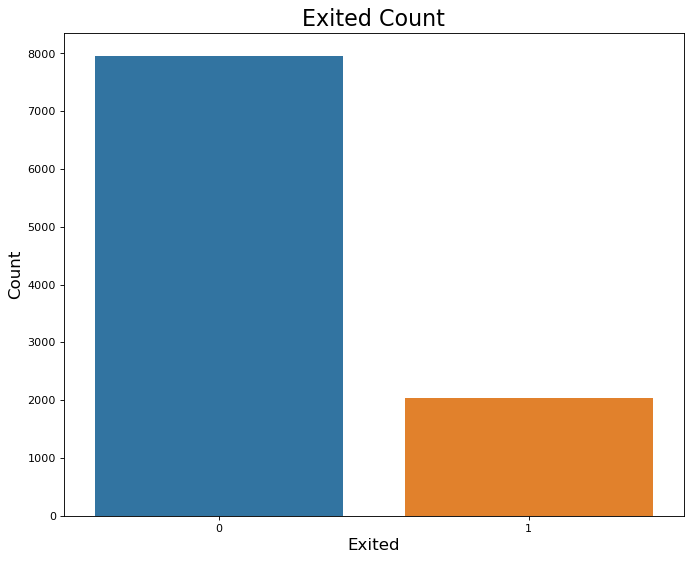

In [56]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df['Exited'])
plt.title('Exited Count', size =20)
plt.xlabel("Exited",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- 80% of customers don't move into competitor (better than average world bank churn which is about 25%)

#### Credit Score Group

In [57]:
df['credit_score_group'].value_counts()

Fair           3331
Good           2428
Very Poor      2362
Very Good      1224
Exceptional     655
Name: credit_score_group, dtype: int64

In [58]:
df['credit_score_group'].value_counts(normalize=True)

Fair          0.33
Good          0.24
Very Poor     0.24
Very Good     0.12
Exceptional   0.07
Name: credit_score_group, dtype: float64

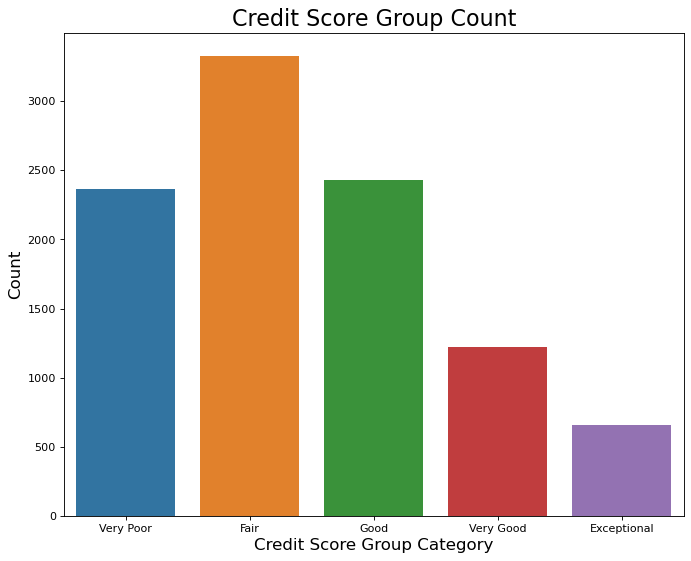

In [59]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot(df['credit_score_group'])
plt.title('Credit Score Group Count', size =20)
plt.xlabel("Credit Score Group Category",size = 15)
plt.ylabel("Count", size = 15)
plt.show()

- Majority customers have fair credit score 

### MULTIVARIATE ANALYSIS

In [60]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,credit_score_group,age_group
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Fair,Middle-Aged Adults
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Fair,Middle-Aged Adults
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Very Poor,Middle-Aged Adults
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Good,Middle-Aged Adults
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Exceptional,Middle-Aged Adults


#### CreditScore VS Exited

In [61]:
df_cs = df.pivot_table(index='credit_score_group', values='Exited', aggfunc='sum').sort_values('Exited', ascending = False).reset_index()
df_cs

,credit_score_group,Exited
0,Fair,685
1,Very Poor,520
2,Good,452
3,Very Good,252
4,Exceptional,128


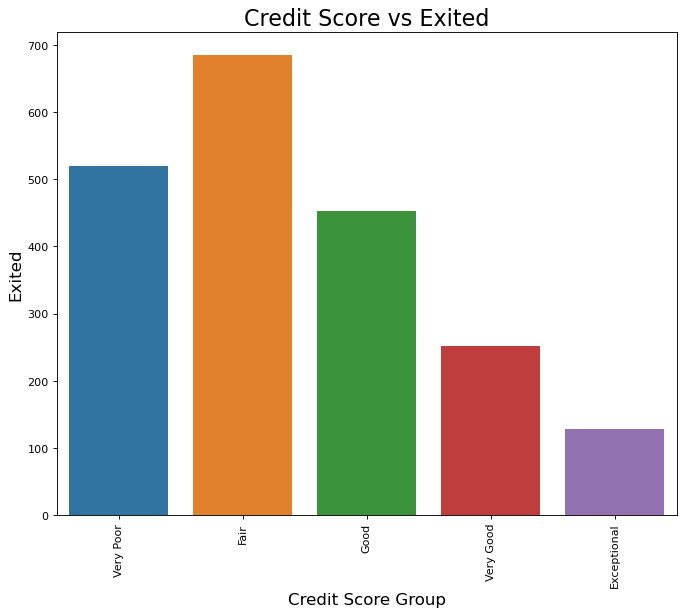

In [62]:
plt.figure(figsize=(10,8), dpi = 80)
sns.barplot(x= 'credit_score_group' , y = 'Exited', data = df_cs, estimator=sum)
plt.title('Credit Score vs Exited', size =20)
plt.xlabel("Credit Score Group", size = 15)
plt.ylabel("Exited", size = 15)
plt.xticks(rotation=90)
plt.show()

In [63]:
pd.crosstab(index = df['credit_score_group'], columns = df['Exited'], normalize = 'index')

Exited,0,1
credit_score_group,,
Very Poor,0.78,0.22
Fair,0.79,0.21
Good,0.81,0.19
Very Good,0.79,0.21
Exceptional,0.80,0.20


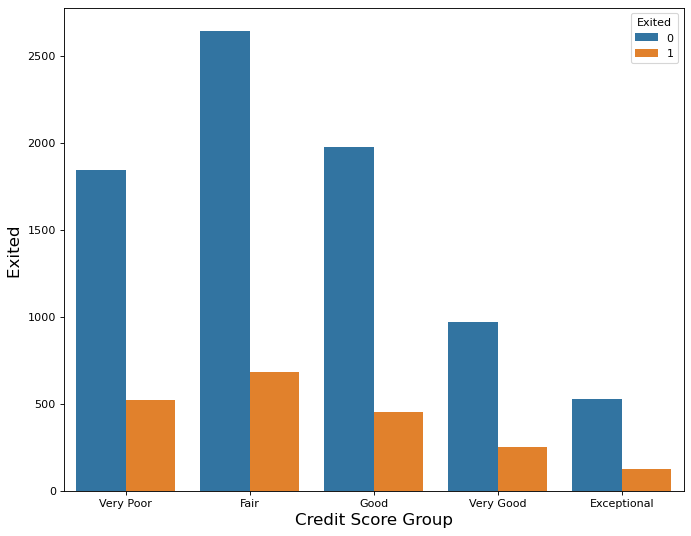

In [64]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('credit_score_group', data = df, hue = 'Exited')
plt.xlabel("Credit Score Group",size = 15)
plt.ylabel("Exited ", size = 15)
plt.show()

- Credit Score has no significant impact to Exited customers (all credit score group have similar Exited rate)

#### Geography VS Exited

In [65]:
df_Geography = df.pivot_table(index='Geography', values='Exited', aggfunc='sum').sort_values('Exited', ascending = False).reset_index()
df_Geography

,Geography,Exited
0,Germany,814
1,France,810
2,Spain,413


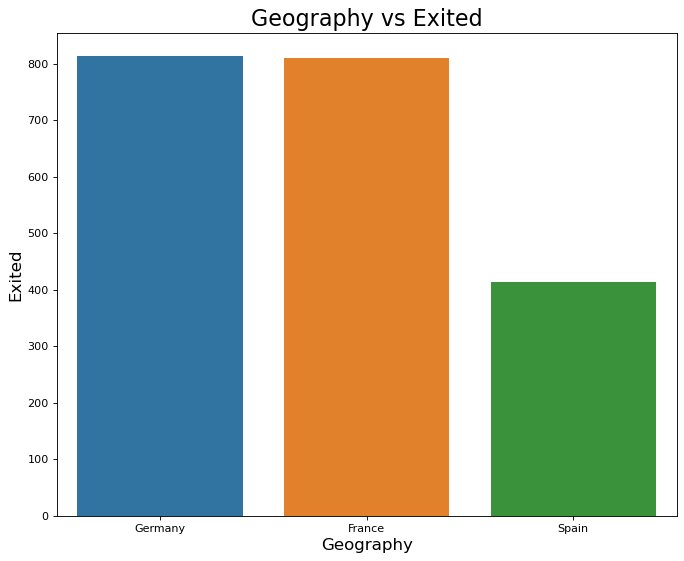

In [66]:
plt.figure(figsize=(10,8), dpi = 80)
sns.barplot(x= 'Geography' , y = 'Exited', data = df_Geography, estimator=sum)
plt.title('Geography vs Exited', size =20)
plt.xlabel("Geography",size = 15)
plt.ylabel("Exited", size = 15)
plt.show()

In [67]:
pd.crosstab(index = df['Geography'], columns = df['Exited'], normalize = 'index')

Exited,0,1
Geography,,
France,0.84,0.16
Germany,0.68,0.32
Spain,0.83,0.17


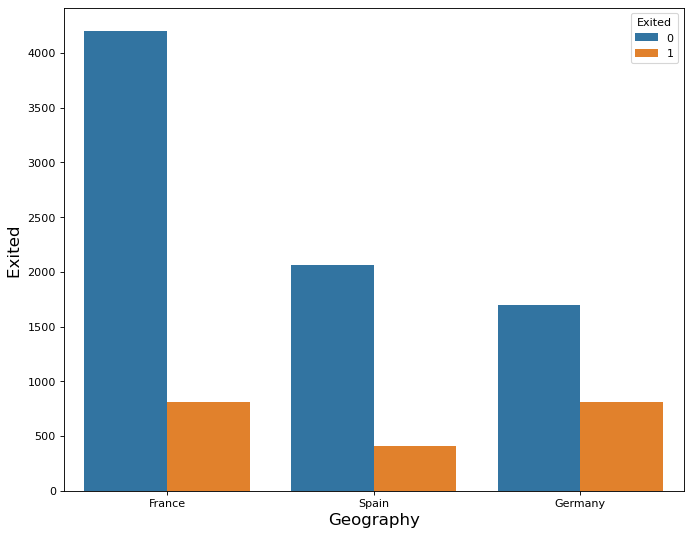

In [68]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('Geography', data = df, hue = 'Exited')
plt.xlabel("Geography",size = 15)
plt.ylabel("Exited ", size = 15)
plt.show()

- Customers who live in Germany have highest Exited Rate (32%) compared to other Geography location

#### Gender vs Exited

In [69]:
df_gender = df.pivot_table(index='Gender', values='Exited', aggfunc='sum').sort_values('Exited', ascending = False).reset_index()
df_gender

,Gender,Exited
0,Female,1139
1,Male,898


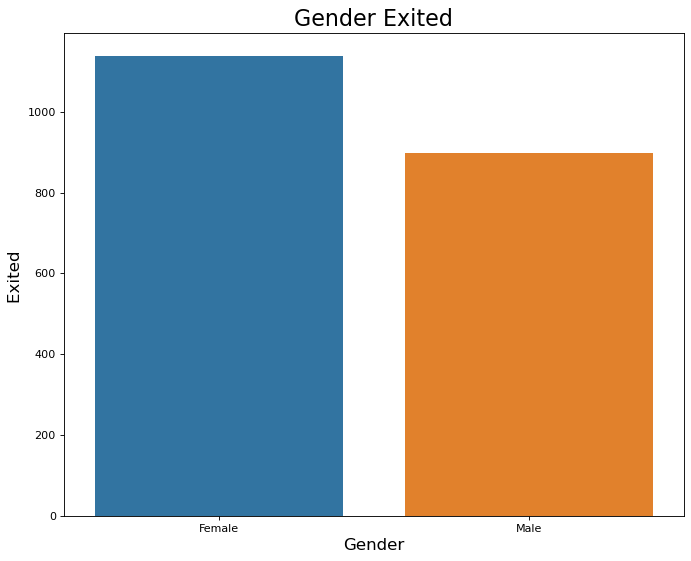

In [70]:
plt.figure(figsize=(10,8), dpi = 80)
sns.barplot(x= 'Gender' , y = 'Exited', data = df_gender, estimator=sum)
plt.title('Gender Exited', size =20)
plt.xlabel("Gender",size = 15)
plt.ylabel("Exited ", size = 15)
plt.show()

In [71]:
pd.crosstab(index = df['Gender'], columns = df['Exited'], normalize = 'index')

Exited,0,1
Gender,,
Female,0.75,0.25
Male,0.84,0.16


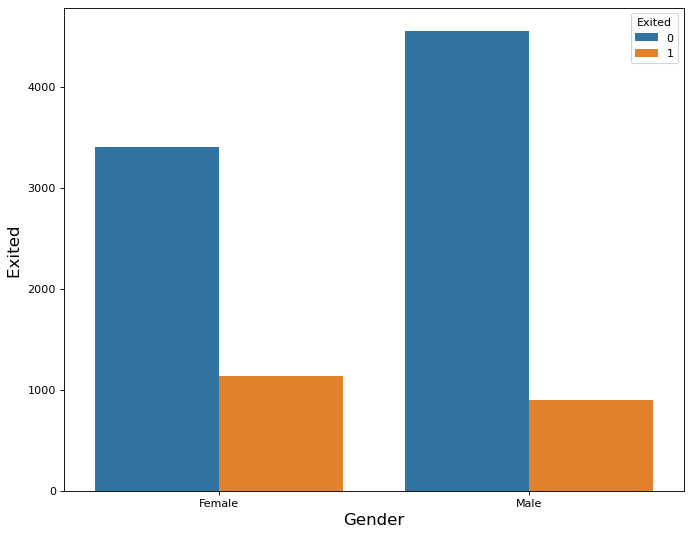

In [72]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('Gender', data = df, hue = 'Exited')
plt.xlabel("Gender",size = 15)
plt.ylabel("Exited ", size = 15)
plt.show()

- Female customers are more likely to exited than Male customers

#### Age vs Exited

In [73]:
df_age = df.pivot_table(index='age_group', values='Exited', aggfunc='sum').sort_values('Exited', ascending=False).reset_index()
df_age

,age_group,Exited
0,Old Adults,957
1,Middle-Aged Adults,932
2,Young Adults,148


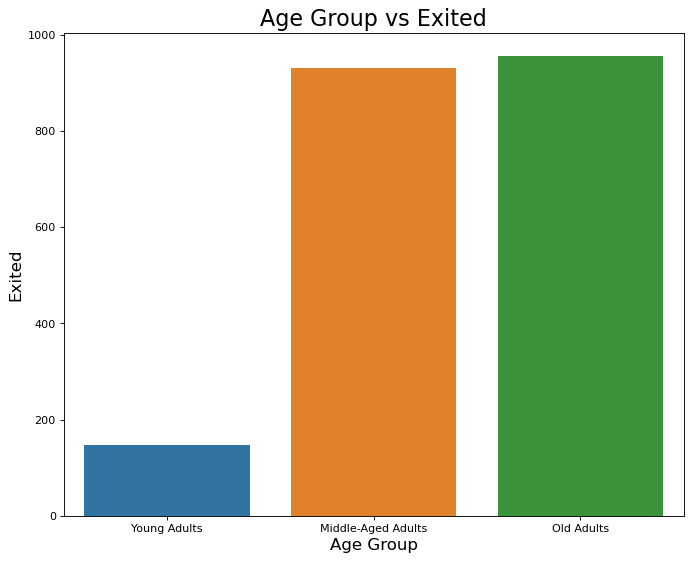

In [74]:
plt.figure(figsize=(10,8), dpi = 80)
sns.barplot(x= 'age_group' , y = 'Exited', data = df_age, estimator=sum)
plt.title('Age Group vs Exited', size =20)
plt.xlabel("Age Group",size = 15)
plt.ylabel("Exited", size = 15)
plt.show()

In [75]:
pd.crosstab(index = df['age_group'], columns = df['Exited'], normalize = 'index')

Exited,0,1
age_group,,
Young Adults,0.92,0.08
Middle-Aged Adults,0.84,0.16
Old Adults,0.55,0.45


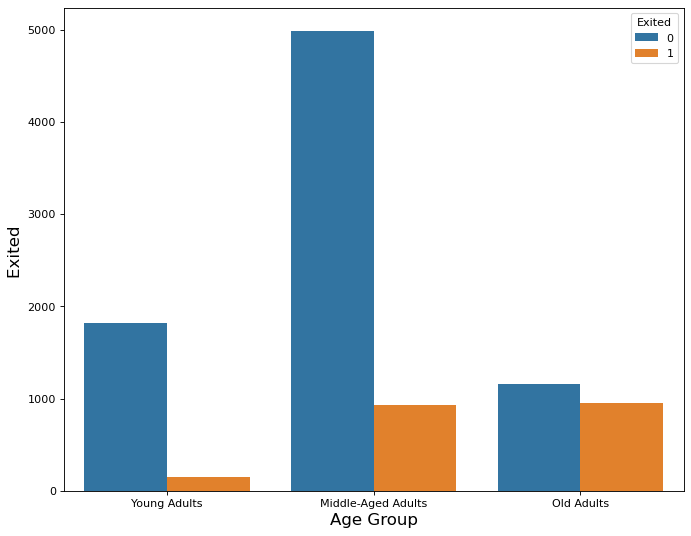

In [76]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('age_group', data = df, hue = 'Exited')
plt.xlabel("Age Group",size = 15)
plt.ylabel("Exited ", size = 15)
plt.show()

- Old Adults have higher Exited percentage than other age group

#### Tenure VS Exited

In [77]:
df_tenure = df.pivot_table(index='Tenure', values='Exited', aggfunc='sum').sort_values('Exited', ascending=False).reset_index()
df_tenure

,Tenure,Exited
0,1,232
1,3,213
2,9,213
3,5,209
4,4,203
5,2,201
6,8,197
7,6,196
8,7,177
9,10,101


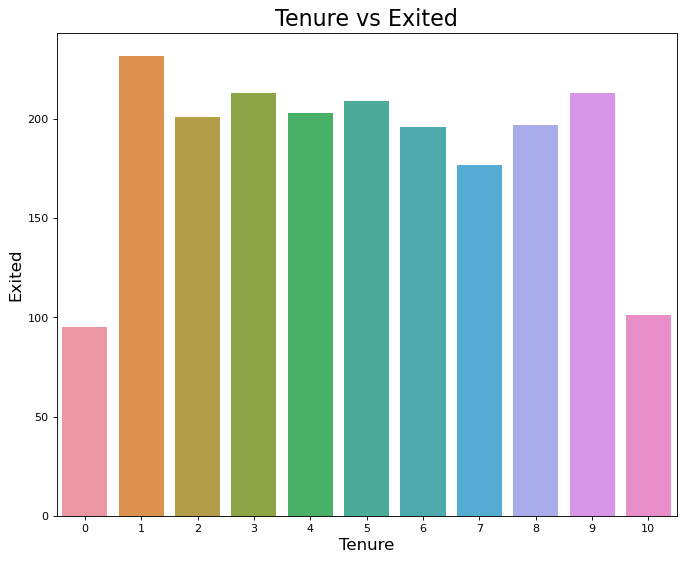

In [78]:
plt.figure(figsize=(10,8), dpi = 80)
sns.barplot(x= 'Tenure' , y = 'Exited', data = df_tenure, estimator=sum)
plt.title('Tenure vs Exited', size =20)
plt.xlabel("Tenure",size = 15)
plt.ylabel("Exited", size = 15)
plt.show()

In [79]:
pd.crosstab(index = df['Tenure'], columns = df['Exited'], normalize = 'index')

Exited,0,1
Tenure,,
0,0.77,0.23
1,0.78,0.22
2,0.81,0.19
3,0.79,0.21
4,0.79,0.21
5,0.79,0.21
6,0.80,0.20
7,0.83,0.17
8,0.81,0.19


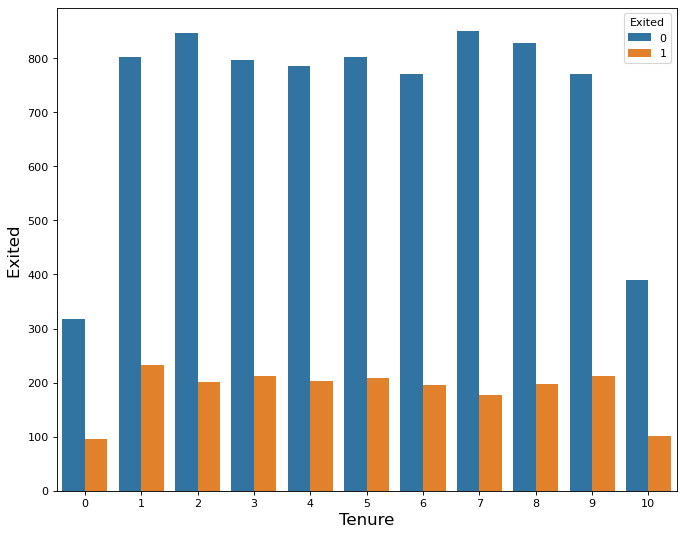

In [80]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('Tenure', data = df, hue = 'Exited')
plt.xlabel("Tenure",size = 15)
plt.ylabel("Exited ", size = 15)
plt.show()

- Tenure has no significant impact on Customer Exited

#### Exited vs Balance

In [81]:
df_balance = df.pivot_table(index='Exited', values='Balance', aggfunc='mean').sort_values('Balance', ascending=False).reset_index()
df_balance

,Exited,Balance
0,1,91108.54
1,0,72745.30


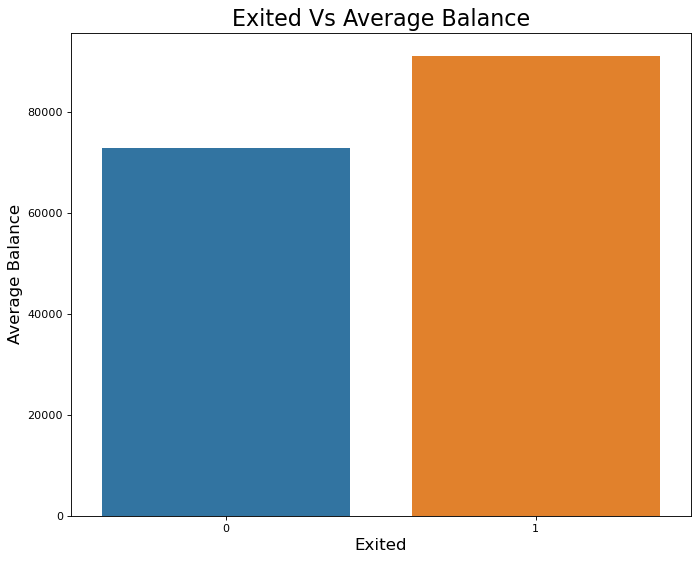

In [82]:
plt.figure(figsize=(10,8), dpi = 80)
sns.barplot(x= 'Exited' , y = 'Balance', data = df_balance, estimator=sum)
plt.title('Exited Vs Average Balance', size =20)
plt.xlabel("Exited",size = 15)
plt.ylabel("Average Balance", size = 15)
plt.show()

- Either Exited Customers or Non-Exited Customers have similar avarage balance amount

#### Number of Products vs Exited

In [83]:
df_nop = df.pivot_table(index='NumOfProducts', values='Exited', aggfunc='sum').sort_values('Exited', ascending=False).reset_index()
df_nop

,NumOfProducts,Exited
0,1,1409
1,2,348
2,3,220
3,4,60


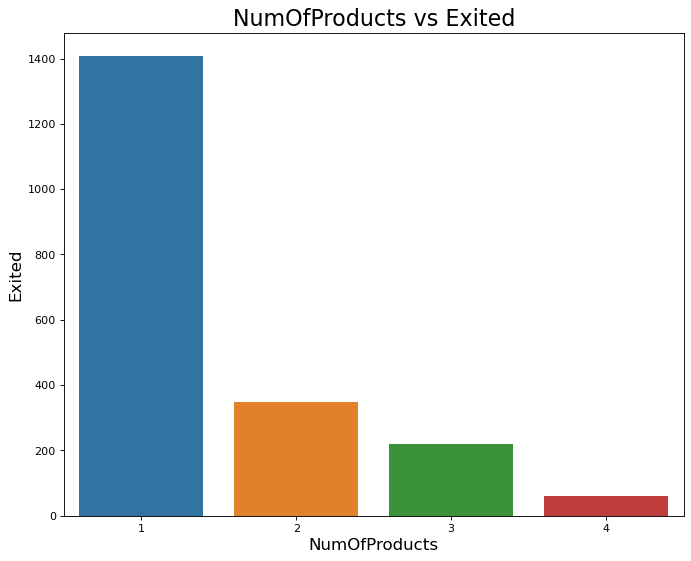

In [84]:
plt.figure(figsize=(10,8), dpi = 80)
sns.barplot(x= 'NumOfProducts' , y = 'Exited', data = df_nop, estimator=sum)
plt.title('NumOfProducts vs Exited', size =20)
plt.xlabel("NumOfProducts",size = 15)
plt.ylabel("Exited", size = 15)
plt.show()

In [85]:
pd.crosstab(index = df['NumOfProducts'], columns = df['Exited'], normalize = 'index')

Exited,0,1
NumOfProducts,,
1,0.72,0.28
2,0.92,0.08
3,0.17,0.83
4,0.00,1.00


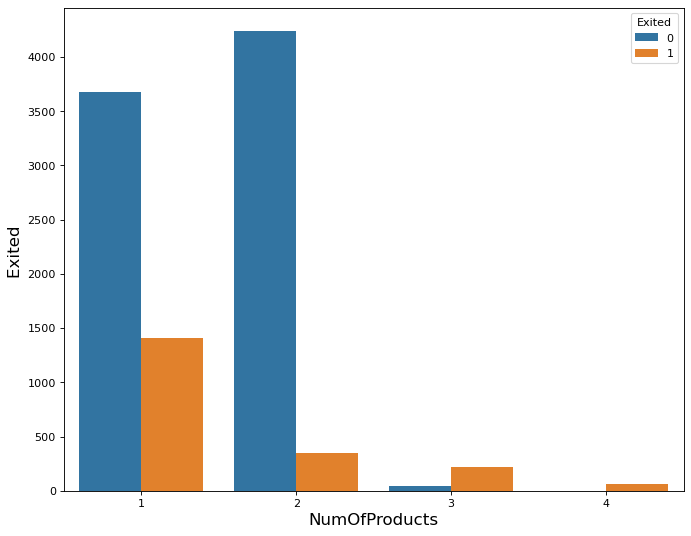

In [86]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('NumOfProducts', data = df, hue = 'Exited')
plt.xlabel("NumOfProducts",size = 15)
plt.ylabel("Exited ", size = 15)
plt.show()

- Customers who have three more product are more likely to Exited

#### Credit Card Ownership vs Exited

In [87]:
df_cc = df.pivot_table(index='HasCrCard', values='Exited', aggfunc='sum').sort_values('Exited', ascending=False).reset_index()
df_cc

,HasCrCard,Exited
0,1,1424
1,0,613


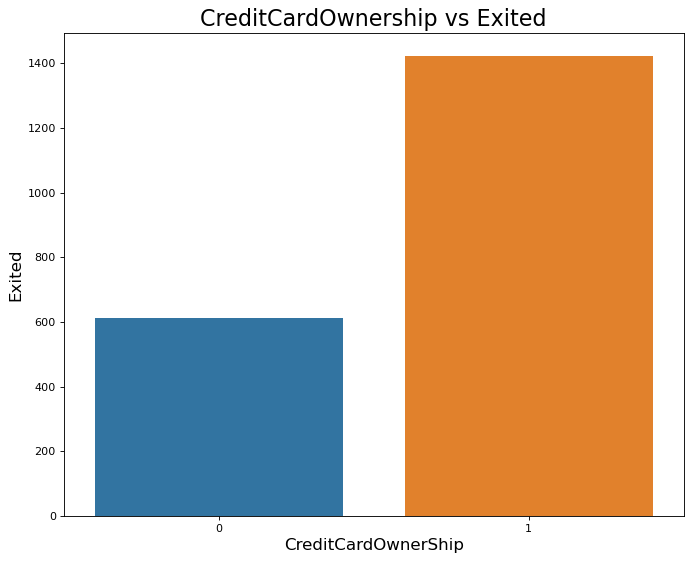

In [88]:
plt.figure(figsize=(10,8), dpi = 80)
sns.barplot(x= 'HasCrCard' , y = 'Exited', data = df_cc, estimator=sum)
plt.title('CreditCardOwnership vs Exited', size =20)
plt.xlabel("CreditCardOwnerShip",size = 15)
plt.ylabel("Exited", size = 15)
plt.show()

In [89]:
pd.crosstab(index = df['HasCrCard'], columns = df['Exited'], normalize = 'index')

Exited,0,1
HasCrCard,,
0,0.79,0.21
1,0.80,0.20


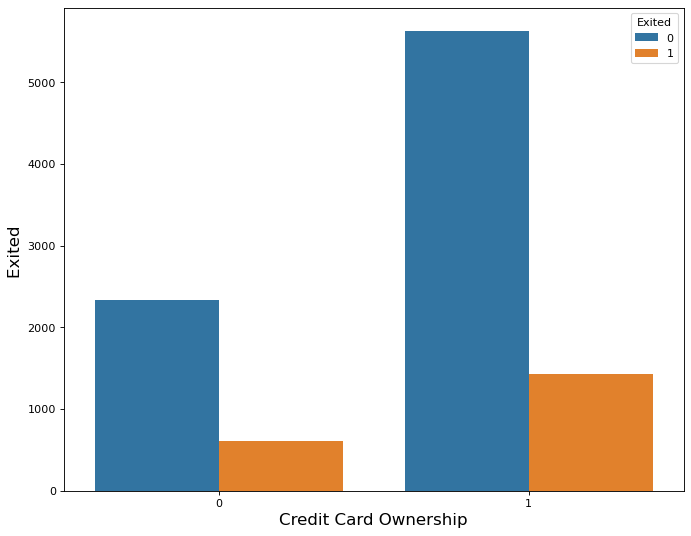

In [90]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('HasCrCard', data = df, hue = 'Exited')
plt.xlabel("Credit Card Ownership",size = 15)
plt.ylabel("Exited ", size = 15)
plt.show()

- Credit Card onwership don't impact significantly to Exited Customers percentage

#### ActiveMember vs Exited

In [91]:
df_am = df.pivot_table(index='IsActiveMember', values='Exited', aggfunc='sum').sort_values('Exited', ascending=False).reset_index()
df_am

,IsActiveMember,Exited
0,0,1302
1,1,735


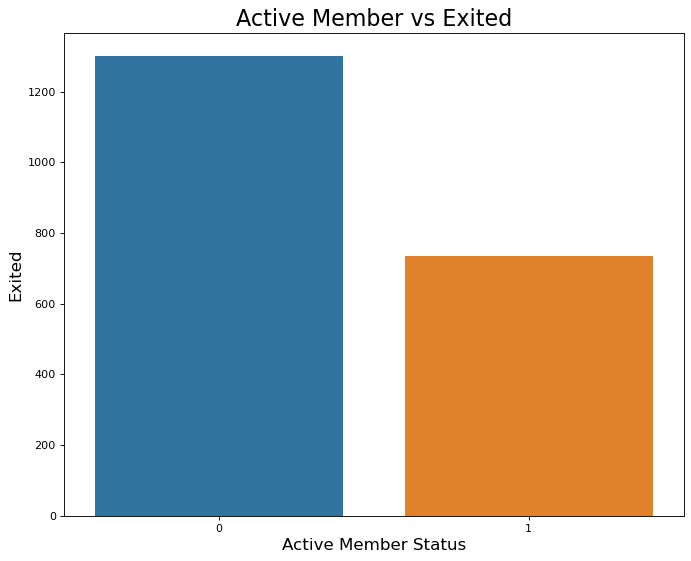

In [92]:
plt.figure(figsize=(10,8), dpi = 80)
sns.barplot(x= 'IsActiveMember' , y = 'Exited', data = df_am, estimator=sum)
plt.title('Active Member vs Exited', size =20)
plt.xlabel("Active Member Status",size = 15)
plt.ylabel("Exited", size = 15)
plt.show()

In [93]:
pd.crosstab(index = df['IsActiveMember'], columns = df['Exited'], normalize = 'index')

Exited,0,1
IsActiveMember,,
0,0.73,0.27
1,0.86,0.14


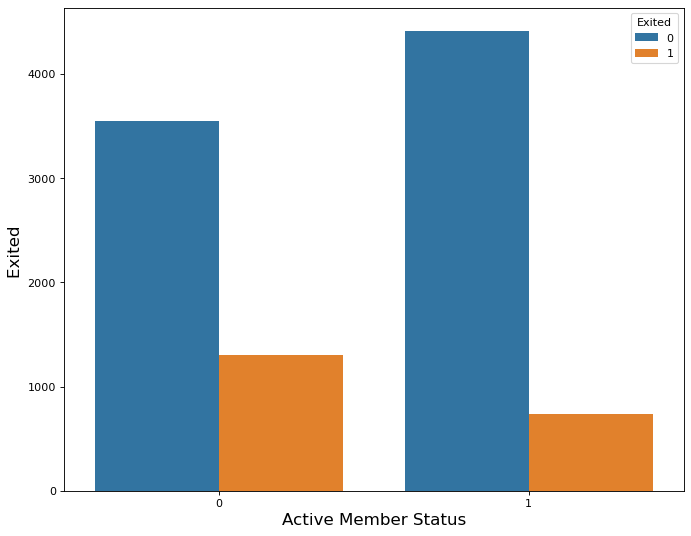

In [94]:
plt.figure(figsize=(10,8), dpi = 80)
sns.countplot('IsActiveMember', data = df, hue = 'Exited')
plt.xlabel("Active Member Status",size = 15)
plt.ylabel("Exited ", size = 15)
plt.show()

- Non-active customer are more likely to exited compared to Active customers

In [95]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,credit_score_group,age_group
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Fair,Middle-Aged Adults
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Fair,Middle-Aged Adults
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Very Poor,Middle-Aged Adults
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Good,Middle-Aged Adults
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Exceptional,Middle-Aged Adults


#### Estimated Salary Vs Exited

In [96]:
df_es = df.pivot_table(index='Exited', values='EstimatedSalary', aggfunc='mean').sort_values('EstimatedSalary', ascending=False).reset_index()
df_es

,Exited,EstimatedSalary
0,1,101465.68
1,0,99738.39


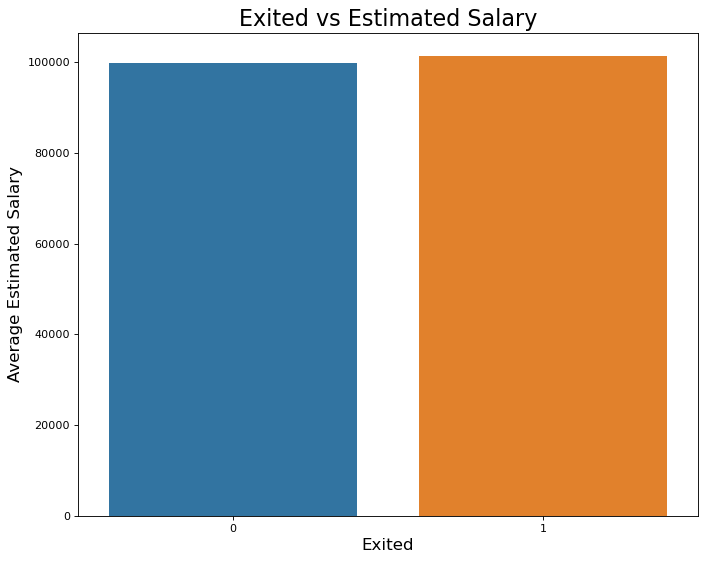

In [97]:
plt.figure(figsize=(10,8), dpi = 80)
sns.barplot(x= 'Exited' , y = 'EstimatedSalary', data = df_es, estimator=sum)
plt.title('Exited vs Estimated Salary', size =20)
plt.xlabel("Exited",size = 15)
plt.ylabel("Average Estimated Salary", size = 15)
plt.show()

- Either Exited customers or Non-Exited customer have similiar average expected salary

# DATA INSIGHT

- Majority customers live at France
- 55% of customers are Male
- Majority customers are in Middle-Aged Adults
- All Tenure period has similar number of customers
- Majority customers have one or two number of products
- Majority customers have credit card
- Number of Active Customers are similar to Number of Non-Active Customers
- 80% of customers don't move into competitor (better than average world bank churn which is about 25%)
- Majority customers have fair credit score 
- Credit Score has no significant impact to Exited customers (all credit score group have similar Exited rate)
- Customers who live in Germany have highest Exited Rate (32%) compared to other Geography location
- Female customers are more likely to exited than Male customers
- Old Adults have higher Exited rate than other age group
- Tenure has no significant impact on Customer Exited
- Either Exited Customers or Non-Exited Customers have similar avarage balance amount
- Customers who have three or more product are more likely to Exited
- Credit Card onwership don't impact significantly to Exited Customers percentage
- Non-active customer are more likely to exited compared to Active customers
- Either Exited customers or Non-Exited customer have similiar average expected salary

# SUMMARY & RECOMMENDATION

- Bank should create retention program for Customers who live in Germany
- Bank should create retention program for Female Customers
- Bank should create retention program for Old Adults Customers
- Bank should not offer more products to customers who have already 2 products => Baned program to buy 3 products
- Bank should create more attractive systems to get more attention from customers, so customer will be more active

For Machine Learning
- Consider to remove credit score features
- Consider to remove tenure features
- Consider to remove hascrcard features